# Excersice 4

Feature selection:

1. You need to load the UCI Arrhythmia dataset
https://archive.ics.uci.edu/ml/datasets/arrhythmia
* the problem is a multi-class classification

2. For comparing the result you need to use kNN (k=3), and compare based on the accuracy with the original dataset (with the all features).

2. Run three different types of feature selection methods (Univariate Statistics, model based, and Iterative Feature Selection).
* The original data set has 279 features.
* You need to run the methods for number_of_features= 20, 50, 100, 150, 200
* All the results should show in the same figure (At the end we have just one figure)

In [1]:
import pandas as pd
import numpy as np
# Put the dataset into a dataframe
arrhythmia_data =  pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data", header=None)
# dtypes for our columns
arrhythmia_data.dtypes

0        int64
1        int64
2        int64
3        int64
4        int64
        ...   
275    float64
276    float64
277    float64
278    float64
279      int64
Length: 280, dtype: object

In [2]:
# Descriptive statistics of the DataFrame
arrhythmia_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,452.0,46.471239,16.466631,0.0,36.00,47.00,58.000,83.0
1,452.0,0.550885,0.497955,0.0,0.00,1.00,1.000,1.0
2,452.0,166.188053,37.170340,105.0,160.00,164.00,170.000,780.0
3,452.0,68.170354,16.590803,6.0,59.00,68.00,79.000,176.0
4,452.0,88.920354,15.364394,55.0,80.00,86.00,94.000,188.0
...,...,...,...,...,...,...,...,...
275,452.0,0.514823,0.347531,-0.8,0.40,0.50,0.700,2.4
276,452.0,1.222345,1.426052,-6.0,0.50,1.35,2.100,6.0
277,452.0,19.326106,13.503922,-44.2,11.45,18.10,25.825,88.8
278,452.0,29.473230,18.493927,-38.6,17.55,27.90,41.125,115.9


We can see that 275 columns were printed, but we have 280 columns (279 features plus the label). There is an issue with 5 columns.

In [4]:
# check to see if there are any columns with missing values 
arrhythmia_data.columns[arrhythmia_data.isnull().any()].tolist()

[]

In [5]:
# Check to see whether any column is an object.
arrhythmia_data.loc[:, arrhythmia_data.dtypes == object]

,10,11,12,13,14
0,13,64,-2,?,63
1,37,-17,31,?,53
2,34,70,66,23,75
3,11,-5,20,?,71
4,13,61,3,?,?
...,...,...,...,...,...
447,4,40,-27,?,63
448,66,52,79,?,73
449,-19,-61,-70,84,84
450,29,-22,43,103,80


In [6]:
question_columns = arrhythmia_data.loc[:, arrhythmia_data.dtypes == object].columns
print("Count the occurence of ? per column:")
for col in question_columns:
    print("Column {:.0f} has {:.0f} '?' occurence(s).".format(col, arrhythmia_data[col].str.contains(r'[?]').sum()))


Count the occurence of ? per column:
Column 10 has 8 '?' occurence(s).
Column 11 has 22 '?' occurence(s).
Column 12 has 1 '?' occurence(s).
Column 13 has 376 '?' occurence(s).
Column 14 has 1 '?' occurence(s).


There are five columns that contain missing values. One column has missing variables above 50%. The rest 4 columns have lower amounts of missing values.

In [8]:
#switch ? for NaN for easier handling
arrhythmia_data[arrhythmia_data=='?'] = np.NaN
#drop columns with more than 50% NaN
arrhythmia_data[13] = arrhythmia_data[13].notnull().astype('int')
arrhythmia_data = arrhythmia_data.astype(float)
column_means = arrhythmia_data.mean(skipna=True)
arrhythmia_data = arrhythmia_data.fillna(column_means)
arrhythmia_data.shape

(452, 280)

In [9]:
X = arrhythmia_data.iloc[:,:-1]
y = arrhythmia_data.iloc[:,-1].astype(int)
X.shape

(452, 279)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Our benchmark model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)
# scale the dataset to have mean equal to 0 and std equal to 1
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train_scaled, y_train)
print("Training set score: {:.3f}".format(KNN.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(KNN.score(X_test_scaled, y_test)))

Training set score: 0.687
Test set score: 0.593


In [12]:
# Utility function to report best scores

def get_best_score(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [14]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from time import time
import warnings
#warnings.filterwarnings("ignore")
warnings.resetwarnings()
pipe = Pipeline([
  ('scaler', StandardScaler()),
  ('feature_selection', SelectKBest()),
  ('classification', KNeighborsClassifier(n_neighbors=3))
])

# specify parameters and distributions to sample from
param_grid = [
     {'classification': [KNeighborsClassifier(n_neighbors=3,n_jobs=-1)]},
    
     {'feature_selection': [SelectKBest()],
     'feature_selection__k':[10, 20, 50, 100, 200]},

     {'feature_selection': [SelectFromModel(RandomForestClassifier(random_state=22), threshold=-np.inf)],
     'feature_selection__max_features':[10, 20, 50, 100, 200]},
    
     {'feature_selection': [RFE(RandomForestClassifier(random_state=22))],
     'feature_selection__n_features_to_select':[10, 20, 50, 100, 200]}

]

# run grid search 
grid_search = GridSearchCV(pipe, param_grid, n_jobs = -1)

start = time()
grid_search.fit(X_test, y_test)
get_best_score(grid_search.cv_results_)
stop = time()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model with rank: 1
Mean validation score: 0.655 (std: 0.088)
Parameters: {'feature_selection': SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n

gridSearchCV took 147.01 seconds


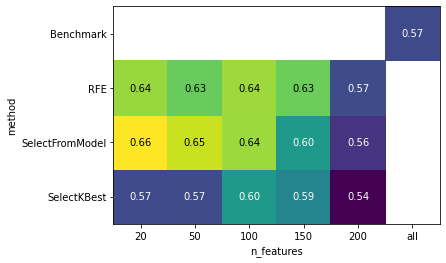

In [16]:
print("gridSearchCV took %.2f seconds" % ((stop - start)))
import mglearn
selection_method = ["SelectKBest", "SelectFromModel", "RFE", "Benchmark"]
method = [20, 50, 100, 150, 200, "all"]
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.iloc[-15:].mean_test_score).reshape(3,5)
# some manipulation to add benchmark score to the same array
column_to_be_added = np.array([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, results.mean_test_score[0]])
final = np.empty((3,6))
final[:] = np.NaN
final[:,:-1] = scores
# Adding benchmark row to numpy array
scores = np.vstack([final, column_to_be_added])
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='n_features', xticklabels=method,
ylabel='method', yticklabels=selection_method, cmap="viridis")

The score with no feature selection method (Benchmark) is 0.57. We can see in the heatmap above that all feature selection methods manage to increase the accuracy of the model for most of n_features. The best feature selection method for this problem though, seems to be the SelectFromModel method with 20 features, a model based method with a GridsearchCV score equal to 0.66.

In [17]:
#We retrain the highest performing model from GridSearchCV with the whole train dataset and examine the score result in test set
best_model = grid_search.best_estimator_.fit(X_train,y_train)
print("Train set score: {:.2f}".format(best_model.score(X_train, y_train)))
print("Test set score: {:.2f}".format(best_model.score(X_test, y_test)))

Train set score: 0.75
Test set score: 0.68


In [18]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  ccp_alpha=0.0,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  max_samples=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_im

In [19]:
# just a test to make sure that scaling in the pipeline for the test sample was done correctly
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pipetest = Pipeline(steps=[('feature_selection', SelectFromModel(estimator=RandomForestClassifier(random_state=22),
                                 max_features=20, threshold=-np.inf)),
                ('classification', KNeighborsClassifier(n_neighbors=3))])

pipetest.fit(X_train_scaled,y_train)
print("Train set score: {:.2f}".format(pipetest.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(pipetest.score(X_test_scaled, y_test)))


Train set score: 0.79
Test set score: 0.65


Without using any featureselection method we had scores equal to:
Training set score: 0.687
Test set score: 0.593

After creating a pipeline with GridSearchCV and testing 3 feature selection methods for different number of features, we selected the SelectFromModel with 20 features as the best one. The score of the model increased, both in the training set, as well as in the test set. We conclude that the feature selection method had a positive result in the performance of our model in this problem.